# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [1]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [2]:
all_data_fp = "../../analysis_data/all_data.csv"

In [3]:
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_3227/2865108240.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89813,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89814,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89815,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89816,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [4]:
overrides = [
    # "game.universe=c1",

    # "game.universe=100",
    # "game.num_signals=100",

    "game.universe=2ball_300",
    "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

#### Meaning distributions

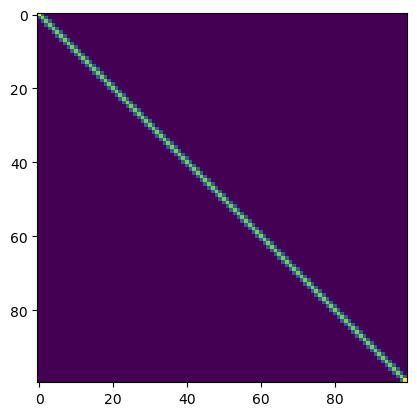

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

#### helper function for subsetting

In [6]:
def get_df_subsetted_by_bound(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

### Subset dataframes for plotting

In [7]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
29779,2.983033,2.951033,2.160638,20.342525,0.024574,-0.03067,0.742355,0.0,simulation,NaN,...,-8,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29780,5.797586,4.268979,0.842691,1685.243800,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29781,2.810301,2.755800,2.355870,39.393944,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29782,2.821302,2.785093,2.326578,28.110016,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29783,2.802565,2.773570,2.338101,26.525960,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,100,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89813,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89814,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89815,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
89816,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [8]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

### Plot

#### Trade-offs

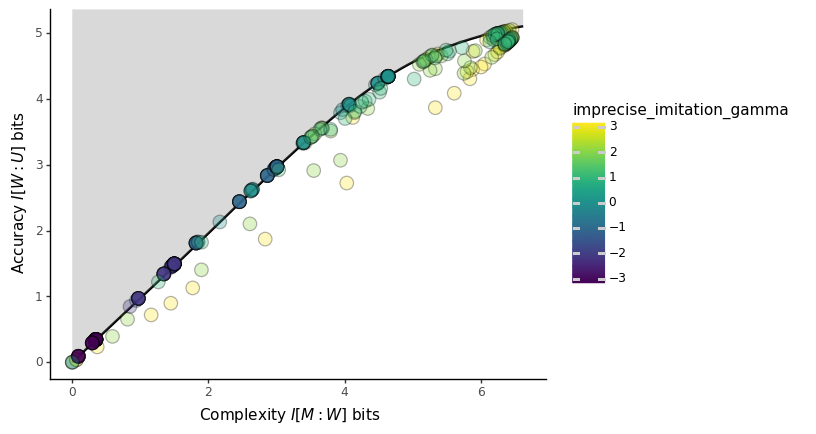

In [9]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)